In [105]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from pyproj import CRS, Proj, transform

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, plot, iplot

import pystan

In [2]:
sns.set()

plt.rcParams['figure.figsize'] = (12, 8)

In [103]:
%load_ext jupyterstan

In [3]:
df = pd.read_excel("counter_data.xlsx")

In [4]:
df = df[['CounterReadingID', 'StartTime', 'EndTime', 'Visits', 'CounterID_ASTA', 'ASTA_Counters.RegionalUnit', 'PAVE_Counters.CoordinateNorth', 'PAVE_Counters.CoordinateEast']]

df.columns = ['id', 'start', 'end', 'visits', 'counter', 'park', 'north', 'east']

df = df.dropna()

df['duration'] = df.end - df.start

df = df.astype({"visits": int, "counter": int, "park": int, 'north': int, 'east': int})

In [5]:
df_hourly = df[(df.duration == np.timedelta64(1, 'h')) & (df.park == 625)].sort_values('start')

In [16]:
df_counters = df_hourly.groupby('counter').resample('1d', on='start').sum()[['visits']]

In [39]:
df_counters

visits
counter start             
912     2015-01-01      73
        2015-01-02      77
        2015-01-03       5
        2015-01-04      17
        2015-01-05      28
...                    ...
1246    2019-09-29      63
        2019-09-30      10
        2019-10-01      21
        2019-10-02      55
        2019-10-03       8

[8896 rows x 1 columns]

In [44]:
counter_ids = np.unique(df_counters.index.get_level_values('counter'))

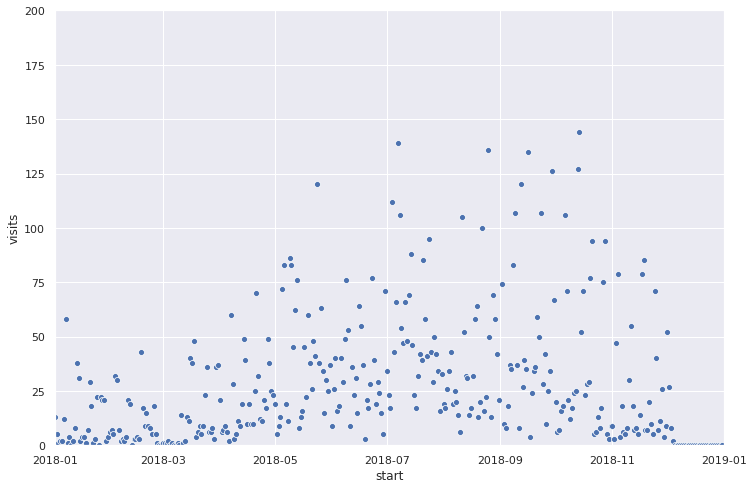

(365, 1)

In [136]:
idx = 5  # 0..5
year_start = 2018
year_end = year_start + 1

counter_id = counter_ids[idx]

df_plot = df_counters[df_counters.index.get_level_values('start') < pd.datetime(year_end, 1, 1)]
df_plot = df_plot[pd.datetime(year_start, 1, 1) <= df_plot.index.get_level_values('start')]

sns.scatterplot(x=df_plot.loc[counter_id].index, y='visits', data=df_plot.loc[counter_id])
plt.xlim(pd.datetime(year_start, 1, 1), pd.datetime(year_end, 1, 1))
plt.ylim(0, 200)
plt.show()
df_plot.loc[counter_id].shape

In [191]:
%%stan model

data {
    int<lower=0> N; // number of counters
    int<lower=0> T; // number of days
    vector[T] t; // day number
    vector[T] y[N]; // recorded visitors
}

parameters {
    vector[3] mu_0;
    vector<lower=0>[3] sigma_0;
    vector[3] abc[N];
    
    real<lower=0> sigma;
    
}

transformed parameters {
    vector[T] mu[N];

    for (i in 1:N) {
        mu[i] = abc[i][1] * t .* t + abc[i][2] * t + abc[i][3];  // change to autoregressive?
    }

}

model {
    // mu_0 ~ normal(0., 1000.); // prior, make 3D maybe
    // sigma_0 ~ inv_chi_square(1000.);
    
    for (i in 1:N) {
        for (j in 1:3) {
            abc[i][j] ~ normal(mu_0[j], sigma_0[j]);
        }
    }
    
    for (i in 1:N) {
        y[i] ~ normal(mu[i], sigma);
    }
    
}

generated quantities {
    vector[T] ypred[N];
    
    for (i in 1:N) {
        for (time in 1:T) {
            ypred[i][time] = normal_rng(mu[i][time], sigma);
        }
    }
    
}


INFO:pystan:COMPILING THE C++ CODE FOR MODEL model_c65e869723986b3a9e9d3ebb67b64012 NOW.


Creating pystan model & assigning it to variable name "model".
Stan options:
 {'model_name': 'model', 'include_paths': None, 'boost_lib': None, 'eigen_lib': None, 'verbose': False, 'obfuscate_model_name': True}
StanModel now available as variable "model"!
Compilation took a minute.


In [192]:
data_visitors = df_plot.unstack().values

In [193]:
data_dict = {
    'N': 6,
    'T': 365,
    't': range(0, 365),
    'y': data_visitors
    
}

In [195]:
fit = model.sampling(data=data_dict, iter=100, warmup=100, chains=2)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
/home/redtachyon/anaconda3/envs/bda/lib/python3.7/site-packages/pystan/diagnostics.py:213: RuntimeWarning:

invalid value encountered in true_divide

/home/redtachyon/anaconda3/envs/bda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3367: RuntimeWarning:

Degrees of freedom <= 0 for slice

/home/redtachyon/anaconda3/envs/bda/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning:

invalid value encountered in true_divide

/home/redtachyon/anaconda3/envs/bda/lib/python3.7/site-packages/numpy/core/_methods.py:130: RuntimeWarning:

invalid value encountered in true_divide



In [199]:
fit

ValueError: Stan model model_c65e869723986b3a9e9d3ebb67b64012 contains no samples.

In [165]:
coords = df_hourly.apply(lambda x: (x[7], x[6]), axis=1).unique()

In [166]:
# Coordinate conversion template
crs = CRS.from_epsg(3067)

in_proj = Proj('epsg:3067')
out_proj = Proj('merc')

# x, y = transform(in_proj, out_proj, df_hourly.east.values[1000], df_hourly.north.values[1000])

# x, y

In [167]:
merc_coords = []
for east, north in coords:
    merc_coords.append(transform(in_proj, out_proj, east, north))

In [168]:
merc_coords

[(60.303525451006834, 24.550391008969527),
 (60.33073081360451, 24.492838046488888),
 (60.27581963490531, 24.46368928427852),
 (60.326924542956334, 24.495358359272675),
 (60.29819039594651, 24.45628974906327),
 (60.28242199633351, 24.505873789599413)]